In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tifffile as tf
import pickle
from datetime import datetime
import os
from skimage.color import label2rgb

In [18]:
def show_anns(anns,display=True,randomColors=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #ax = plt.gca()
    #ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        if randomColors:
            color_mask = np.concatenate([np.random.random(3), [0.35]])
        else:
            color_mask = np.asarray([1,0,0,0.35])    % make them all red
        img[m] = color_mask
    
    if display:
        ax.imshow(img)
    else:
        return img
    
    
def show_anns_EDX(anns,abundance_tile,colors,display=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #ax = plt.gca()
    #ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        
        tmp_img = np.zeros((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1]))
        tmp_img[m] = 1
        tmp_abundance_masked = tmp_img*abundance_tile
        temp_sum = np.sum(np.sum(tmp_abundance_masked,axis=1),axis=1)
        color_idx = np.argmax(temp_sum)
        color_mask = np.concatenate([colors[color_idx], [0.35]])
        img[m] = color_mask
    return img
    #ax.imshow(img)

### EDX colors of interest

In [9]:
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

### load the stack of haadfs, SAM masks, abundance maps

In [5]:
# haadf stack
haadf_stack = tf.imread("../../../../primary_data/main_mosaic_5by6_haadf.tiff")  

# location of SAM masks
masks_path = '../../../../primary_data/main_mosaic_6by5/SAM_masks/'

# abundance maps
abundance_maps = np.load("../../../../primary_data/abundance_maps.npz")['arr_0']
print('abundance maps shape',abundance_maps.shape)

abundance maps shape (11, 1024, 1024, 30)


### Apply the SAM/EDX routine to a single tile

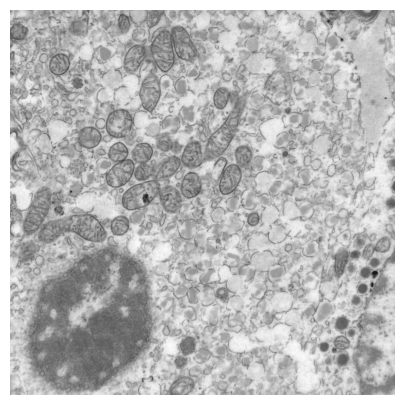

In [6]:
# Show haadf
tile_idx = 0
haadf = haadf_stack[tile_idx,:,:]
fig,ax = plt.subplots(figsize=(5,5))
plt.imshow(haadf,cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# Get the masks
file = open(os.path.join(masks_path,'tile_%02d.pkl' % tile_idx),'rb')
masks = pickle.load(file)

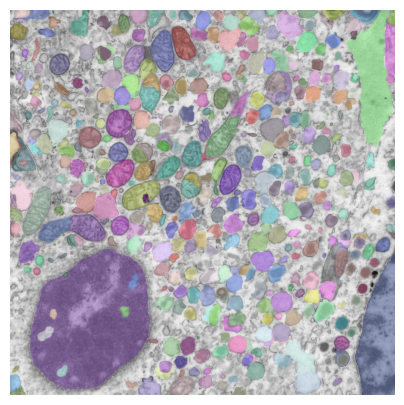

In [19]:
# Show the masks over the Haadf
%matplotlib inline
f,ax= plt.subplots(figsize=(5,5))
plt.imshow(haadf,cmap='gray')
show_anns(masks,display=True)
plt.axis('off')
plt.show() 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


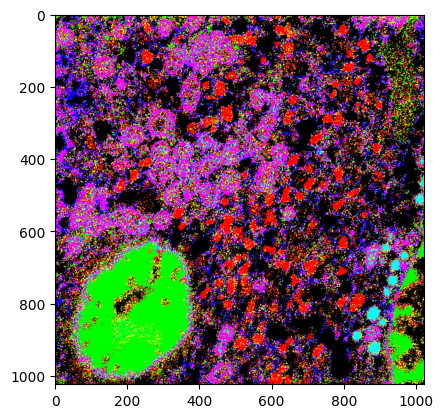

In [14]:
# Abundance for a single tile
abundance_tile = abundance_maps[indices,:,:,tile_idx]

label_img = np.argmax(abundance_tile,axis=0)+1 
coeff_img = np.max(abundance_tile,axis=0) 
overlay_img = label2rgb(label_img,image=None, colors=colors,bg_label=-1,bg_color=[0,0,0],kind='overlay')
overlay_img = np.multiply(overlay_img,np.repeat(coeff_img[:, :, np.newaxis], 3, axis=2))

plt.imshow(overlay_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAM segmentaion + EDX colorEM')

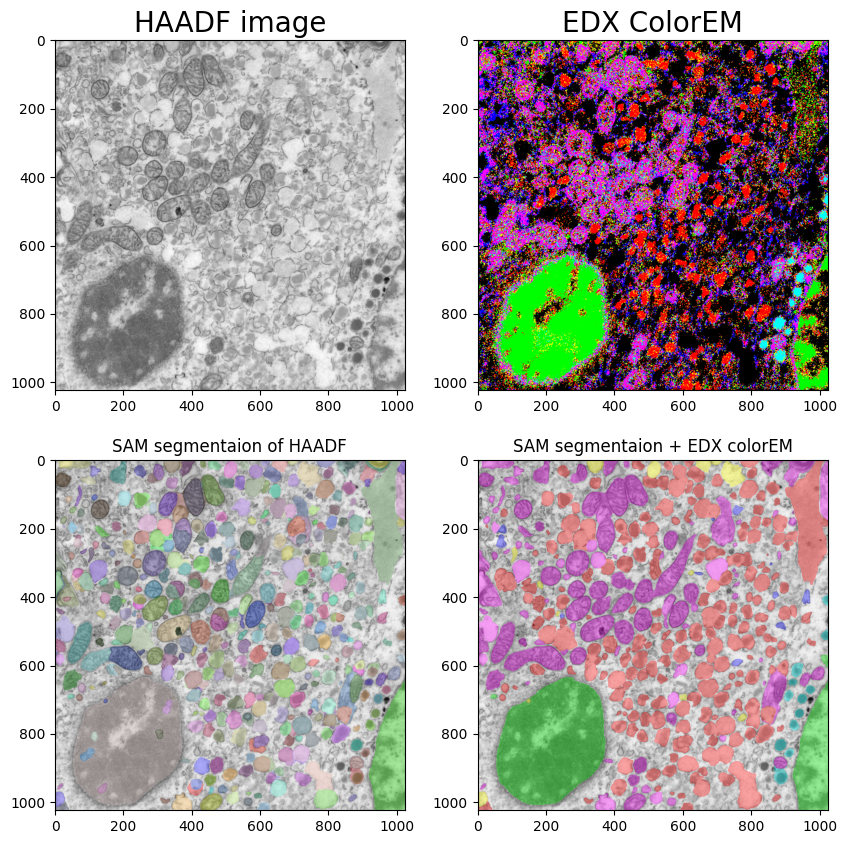

In [22]:
f,ax = plt.subplots(2,2,figsize=(10,10))

ax[0][0].imshow(haadf,cmap='gray')
ax[0][0].set_title('HAADF image',fontsize=20)

ax[0][1].imshow(overlay_img)
ax[0][1].set_title('EDX ColorEM',fontsize=20)

ax[1][0].imshow(haadf,cmap='gray')
ax[1][0].imshow(show_anns(masks,display=False))
ax[1][0].set_title('SAM segmentaion of HAADF',fontsize=12)


ax[1][1].imshow(haadf,cmap='gray')
ax[1][1].imshow(show_anns_EDX(masks,abundance_tile,colors))
ax[1][1].set_title('SAM segmentaion + EDX colorEM',fontsize=12)